<a href="https://colab.research.google.com/github/calcoach/facialrecognition/blob/master/MTCNN_VGG_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install mtcnn
import mtcnn
# print version
print(mtcnn.__version__)

     |████████████████████████████████| 2.3MB 2.4MB/s 
0.1.0


In [5]:
import os
import glob
!pip install -q keras_vggface
#!pip install ipywebrtc
PATH = "/content/drive/My Drive/VGGFace MTCNN"
INPATH = PATH + "/data/videos"

OUTPATH = PATH + "/data/face_images"

folders = list(glob.iglob(os.path.join(INPATH, '*')))

imgurls = !ls -1 "{INPATH}"

for i, folder in enumerate(folders):
  print(folder)

/content/drive/My Drive/VGGFace MTCNN/data/videos/obama
/content/drive/My Drive/VGGFace MTCNN/data/videos/michelle


/content/drive/My Drive/VGGFace MTCNN/data/face_images/obama


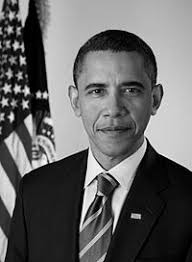

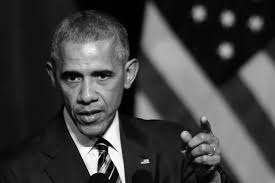

/content/drive/My Drive/VGGFace MTCNN/data/face_images/michelle


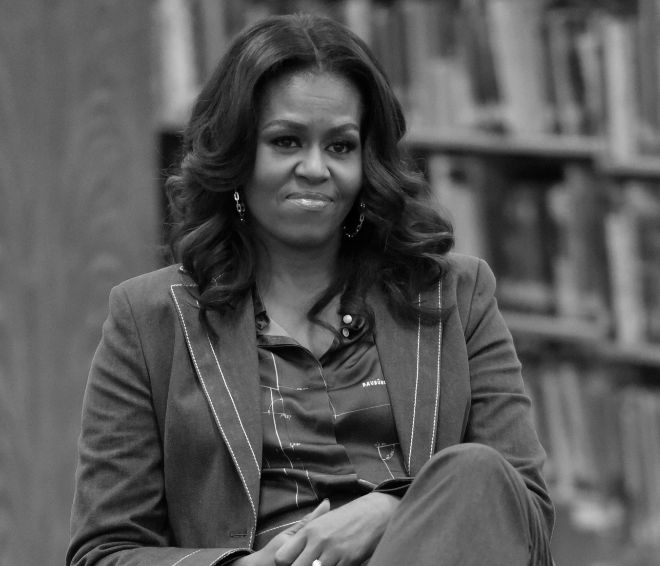

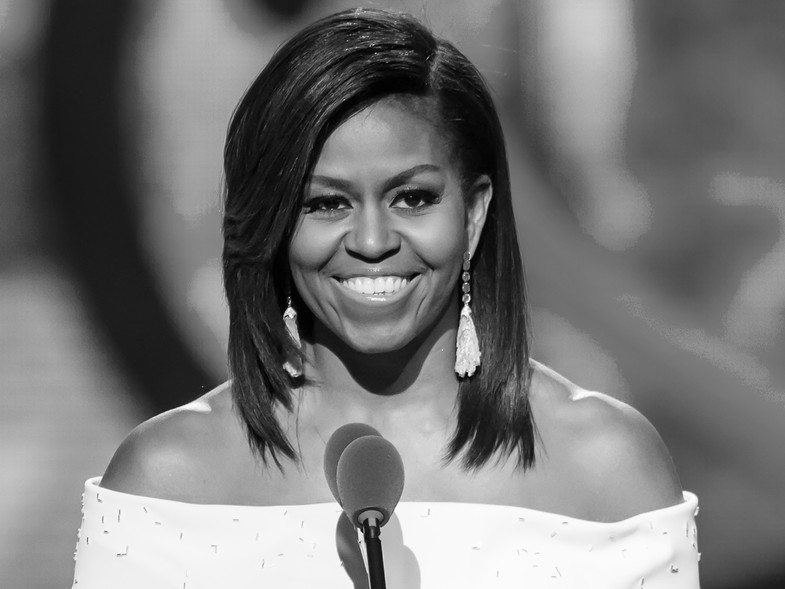

In [0]:
import cv2
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from google.colab.patches import cv2_imshow
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	 image = Image.open(filename)
	# convert to RGB, if needed
	 image = image.convert('RGB')
	# convert to array
	 pixels = asarray(image)
	#open image
	 frame = cv2.imread(filename)
	# create the detector, using default weights
	 detector = MTCNN()
	# detect faces in the image
	 results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	 
	 #(x1, y1, width, height) = results[0]['box']

	 return results


def pickle_stuff(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()


class FaceExtractor(object):
    """
    Singleton class to extraction face images from video files
    """
    CASE_PATH = PATH + "/pretrained_models/haarcascade_frontalface_alt.xml"

    def __new__(cls, weight_file=None, face_size=224):
        if not hasattr(cls, 'instance'):
            cls.instance = super(FaceExtractor, cls).__new__(cls)
        return cls.instance

    def __init__(self, face_size=224):
        self.face_size = face_size

    def crop_face(self, imgarray, section, margin=20, size=224):
        """
        :param imgarray: full image
        :param section: face detected area (x, y, w, h)
        :param margin: add some margin to the face detected area to include a full head
        :param size: the result image resolution with be (size x size)
        :return: resized image in numpy array with shape (size x size x 3)
        """
        img_h, img_w, _ = imgarray.shape
        if section is None:
            section = [0, 0, img_w, img_h]
        (x, y, w, h) = section
        margin = int(min(w,h) * margin / 100)
        x_a = x - margin
        y_a = y - margin
        x_b = x + w + margin
        y_b = y + h + margin
        if x_a < 0:
            x_b = min(x_b - x_a, img_w-1)
            x_a = 0
        if y_a < 0:
            y_b = min(y_b - y_a, img_h-1)
            y_a = 0
        if x_b > img_w:
            x_a = max(x_a - (x_b - img_w), 0)
            x_b = img_w
        if y_b > img_h:
            y_a = max(y_a - (y_b - img_h), 0)
            y_b = img_h
        cropped = imgarray[y_a: y_b, x_a: x_b]
        resized_img = cv2.resize(cropped, (size, size), interpolation=cv2.INTER_AREA)
        resized_img = np.array(resized_img)
        return resized_img, (x_a, y_a, x_b - x_a, y_b - y_a)

    def extract_faces(self, image_file, save_folder):
        face_cascade = cv2.CascadeClassifier(self.CASE_PATH)
    # 0 means the default video capture device in OS
        frame = cv2.imread(image_file)
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = extract_face(image_file)

        if len(faces) == 0:

            print('aqui')
             # only keep the biggest face as the main subject
            face = None
        if len(faces) > 1:  # Get the largest face as main face
            face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
        elif len(faces) == 1:
            face = faces[0]['box']
        if face is not None:
            face_img, cropped = self.crop_face(frame, face, margin=40, size=self.face_size)
            (x, y, w, h) = cropped
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 200, 0), 2)
            imgfile = os.path.basename(image_file).replace(".","_") +"_"+ ".png"
            imgfile = os.path.join(save_folder, imgfile)
            cv2.imwrite(imgfile, face_img)  
   

def main():
    resnet50_features = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3),
                                pooling='avg')  # pooling: None, avg or max
    def image2x(image_path):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = utils.preprocess_input(x, version=1)  # or version=2
        x = preprocess_input(x) 
        
        return x

    def cal_mean_feature(image_folder):
        face_images = list(glob.iglob(os.path.join(image_folder, '*.*')))

        def chunks(l, n):
            """Yield successive n-sized chunks from l."""
            for i in range(0, len(l), n):
                yield l[i:i + n]

        batch_size = 32
        face_images_chunks = chunks(face_images, batch_size)
        fvecs = None
        for face_images_chunk in face_images_chunks:
            images = np.concatenate([image2x(face_image) for face_image in face_images_chunk])
            batch_fvecs = resnet50_features.predict(images)
            if fvecs is None:
                fvecs = batch_fvecs
            else:
                fvecs = np.append(fvecs, batch_fvecs, axis=0)
        return np.array(fvecs).sum(axis=0) / len(fvecs)

    FACE_IMAGES_FOLDER = OUTPATH
    VIDEOS_FOLDER = INPATH
    extractor = FaceExtractor()
    folders = list(glob.iglob(os.path.join(VIDEOS_FOLDER, '*')))
    os.makedirs(FACE_IMAGES_FOLDER, exist_ok=True)
    names = [os.path.basename(folder) for folder in folders]
    
    for i, folder in enumerate(folders):
        name = names[i]
        videos = list(glob.iglob(os.path.join(folder, '*.*')))
        save_folder = os.path.join(FACE_IMAGES_FOLDER, name)
        print(save_folder)
        os.makedirs(save_folder, exist_ok=True)

        for video in videos:
            extractor.extract_faces(video, save_folder)

    precompute_features = []
    for i, folder in enumerate(folders):
        name = names[i]
        save_folder = os.path.join(FACE_IMAGES_FOLDER, name)
        mean_features = cal_mean_feature(image_folder=save_folder)
        precompute_features.append({"name": name, "features": mean_features})
    pickle_stuff(PATH+"/data/precompute_features.pickle", precompute_features)


if __name__ == "__main__":
    main()

In [37]:
from keras.engine import Model
from keras import models
from keras import layers
from keras.layers import Input
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
import numpy as np
from keras_vggface import utils
from scipy import spatial as sp
import cv2
import os
import glob
import pickle
from IPython.display import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow

fourcc = cv2.VideoWriter_fourcc(*'XVID')

def extract_face(frame, required_size=(160,160)):
    detector = MTCNN()
    #detect faces in the image
    results = detector.detect_faces(frame)

    return results


def load_stuff(filename):
    saved_stuff = open(filename, "rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff


class FaceIdentify(object):
    """
    Singleton class for real time face identification
    """
    CASE_PATH = PATH + "/pretrained_models/haarcascade_frontalface_alt.xml"
    VIDEO =  "/content/drive/My Drive/Videos/obama.mp4"

    def __new__(cls, precompute_features_file=None):
        if not hasattr(cls, 'instance'):
            cls.instance = super(FaceIdentify, cls).__new__(cls)
        return cls.instance

    def __init__(self, precompute_features_file=None):
        self.face_size = 224
        self.precompute_features_map = load_stuff(precompute_features_file)
        print("Loading VGG Face model...")
        self.model = VGGFace(model='resnet50',
                             include_top=False,
                             input_shape=(224, 224, 3),
                             pooling='avg')  # pooling: None, avg or max
        print("Loading VGG Face model done")

    @classmethod
    def draw_label(cls, image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
                   font_scale=1, thickness=2):
        size = cv2.getTextSize(label, font, font_scale, thickness)[0]
        x, y = point
        cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
        cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness)

    def crop_face(self, imgarray, section, margin=20, size=224):
        """
        :param imgarray: full image
        :param section: face detected area (x, y, w, h)
        :param margin: add some margin to the face detected area to include a full head
        :param size: the result image resolution with be (size x size)
        :return: resized image in numpy array with shape (size x size x 3)
        """
        img_h, img_w, _ = imgarray.shape
        if section is None:
            section = [0, 0, img_w, img_h]
        (x, y, w, h) = section
        margin = int(min(w, h) * margin / 100)
        x_a = x - margin
        y_a = y - margin
        x_b = x + w + margin
        y_b = y + h + margin
        if x_a < 0:
            x_b = min(x_b - x_a, img_w - 1)
            x_a = 0
        if y_a < 0:
            y_b = min(y_b - y_a, img_h - 1)
            y_a = 0
        if x_b > img_w:
            x_a = max(x_a - (x_b - img_w), 0)
            x_b = img_w
        if y_b > img_h:
            y_a = max(y_a - (y_b - img_h), 0)
            y_b = img_h
        cropped = imgarray[y_a: y_b, x_a: x_b]
        resized_img = cv2.resize(cropped, (size, size), interpolation=cv2.INTER_AREA)
        resized_img = np.array(resized_img)
        return resized_img, (x_a, y_a, x_b - x_a, y_b - y_a)

    def identify_face(self, features, threshold=50):
        distances = []
        for person in self.precompute_features_map:
            person_features = person.get("features")
            distance = sp.distance.euclidean(person_features, features)
            distances.append(distance)
        min_distance_value = min(distances)
        min_distance_index = distances.index(min_distance_value)
        if min_distance_value < threshold:
            return self.precompute_features_map[min_distance_index].get("name")
        else:
            return "?"

    def detect_face(self):
        face_cascade = cv2.CascadeClassifier(self.CASE_PATH)

        cap = cv2.VideoCapture(self.VIDEO);
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter('with10frames.avi', fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))))
        ret = True
        count_frame = 0
        lengh = 0
        faces = None
        predicted_names = None

        while(ret) :

          ret ,  frame = cap.read();
          count_frame = count_frame + 1
          gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

          if(count_frame % 10 == 0 or count_frame == 1):

             faces = extract_face(frame)
             positive_faces = 0

             for i, face in enumerate(faces):
                if(faces[i]['confidence']>0.95):
                  positive_faces = positive_faces + 1

                else :
                  faces.pop(i)
    
              #placeholder for cropped faces
             face_imgs = np.empty((positive_faces, self.face_size, self.face_size, 3))

             for i, face in enumerate(faces):
                if(faces[i]['confidence']>0.95):
                   face_img, cropped = self.crop_face(frame, faces[i]['box'], margin=10, size=self.face_size)
                   (x, y, w, h) = cropped
                   face_imgs[i, :, :, :] = face_img

             if len(face_imgs) > 0:
                 # generate features for each face extracted
                features_faces = self.model.predict(face_imgs)
                predicted_names = [self.identify_face(features_face) for features_face in features_faces]
                print('{} caras {} caras predichas'.format(len(faces),len(predicted_names)))

             print('{}{}{}{}'.format(count_frame/29,' segundos procesados ', (count_frame*100)/total_frames, ' %'))
            # draw results

          if predicted_names != None :

             lengh = len(predicted_names)
            
          for i in range(lengh):

              if count_frame % 10==0:

                 print(' dibujar cara {}'.format(i))
              label = "{}".format(predicted_names[i])
              x,y,w,h = faces[i]['box']
              cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 200, 0), 2)
              self.draw_label(frame, (x, y), label)

          out.write(frame)

       
              


face = FaceIdentify(precompute_features_file=PATH + "/data/precompute_features.pickle")
face.detect_face()



Loading VGG Face model...


KeyboardInterrupt: ignored